In [ ]:
from keras.datasets import imdb
import pandas as pd
import numpy as np
from keras.layers import LSTM, Activation, Dropout, Dense, Input, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from keras.models import Model
import string
import re
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.sequence import pad_sequences
import keras
from sklearn.model_selection import train_test_split

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/ISR Dataset/IMDB Dataset.csv')

data['review'] = data['review'].str.lower()


In [ ]:
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because",
             "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during",
             "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here",
             "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into",
             "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or",
             "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should",
             "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's",
             "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up",
             "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's",
             "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've",
             "your", "yours", "yourself", "yourselves" ]

In [ ]:
def remove_stopwords(data):
  data['review without stopwords'] = data['review'].apply(lambda x : ' '.join([word for word in x.split() if word not in (stopwords)]))
  return data

def remove_tags(string):
    result = re.sub('<.*?>','',string)
    return result


In [ ]:
data_without_stopwords = remove_stopwords(data)
data_without_stopwords['clean_review']= data_without_stopwords['review without stopwords'].apply(lambda cw : remove_tags(cw))
data_without_stopwords['clean_review'] = data_without_stopwords['clean_review'].str.replace('[{}]'.format(string.punctuation), ' ')

In [ ]:
data_without_stopwords.head()

,review,sentiment,review without stopwords,clean_review
0,one of the other reviewers has mentioned that ...,positive,one reviewers mentioned watching just 1 oz epi...,one reviewers mentioned watching just 1 oz epi...
1,a wonderful little production. <br /><br />the...,positive,wonderful little production. <br /><br />the f...,wonderful little production the filming techn...
2,i thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...,thought wonderful way spend time hot summer we...
3,basically there's a family where a little boy ...,negative,basically family little boy (jake) thinks zomb...,basically family little boy jake thinks zomb...
4,"petter mattei's ""love in the time of money"" is...",positive,"petter mattei's ""love time money"" visually stu...",petter mattei s love time money visually stu...


In [ ]:

reviews = data_without_stopwords['clean_review']
reviews

0        one reviewers mentioned watching just 1 oz epi...
1        wonderful little production  the filming techn...
2        thought wonderful way spend time hot summer we...
3        basically family little boy  jake  thinks zomb...
4        petter mattei s  love time money  visually stu...
                               ...                        
49995    thought movie right good job  wasn t creative ...
49996    bad plot  bad dialogue  bad acting  idiotic di...
49997    catholic taught parochial elementary schools n...
49998    going disagree previous comment side maltin on...
49999    no one expects star trek movies high art  fans...
Name: clean_review, Length: 50000, dtype: object

In [ ]:
reviews_list = []
for i in range(len(reviews)):
  reviews_list.append(reviews[i])



In [ ]:
sentiment = data_without_stopwords['sentiment']

In [ ]:
y = np.array(list(map(lambda x: 1 if x=="positive" else 0, sentiment)))

In [ ]:
y

array([1, 1, 1, ..., 0, 0, 0])

In [ ]:
X_train, X_test,Y_train, Y_test = train_test_split(reviews_list, y, test_size=0.2, random_state = 45)

In [ ]:
len(Y_train)

40000

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

In [ ]:
words_to_index = tokenizer.word_index

In [ ]:
len(words_to_index)

95419

In [ ]:
def read_glove_vector(glove_vec):
  with open(glove_vec, 'r', encoding='UTF-8') as f:
    words = set()
    word_to_vec_map = {}
    for line in f:
      w_line = line.split()
      curr_word = w_line[0]
      word_to_vec_map[curr_word] = np.array(w_line[1:], dtype=np.float64)



  return word_to_vec_map


In [ ]:
word_to_vec_map = read_glove_vector('/content/drive/MyDrive/ISR Dataset/glove.6B.50d.txt')

In [ ]:
maxLen = 150


In [ ]:

vocab_len = len(words_to_index)
embed_vector_len = word_to_vec_map['moon'].shape[0]

emb_matrix = np.zeros((vocab_len, embed_vector_len))

for word, index in words_to_index.items():
  embedding_vector = word_to_vec_map.get(word)
  if embedding_vector is not None:
    emb_matrix[index, :] = embedding_vector

embedding_layer = Embedding(input_dim=vocab_len, output_dim=embed_vector_len, input_length=maxLen, weights = [emb_matrix], trainable=False)






In [ ]:
from keras.layers import Bidirectional

In [ ]:
#model=imdb_rating(input_shape)
def imdb_rating(input_shape):

  X_indices = Input(input_shape)

  embeddings = embedding_layer(X_indices)

  X =Bidirectional(LSTM(128, return_sequences=True))(embeddings)

  X = Dropout(0.3)(X)

  X = Bidirectional(LSTM(128))(X)

  X = Dropout(0.3)(X)

  #X = LSTM(128)(X)
  #X = Dense(64)
  #X = Dropout(0.3)

  X = Dense(1, activation='sigmoid')(X)

  model = Model(inputs=X_indices, outputs=X)

  return model

In [ ]:
model = imdb_rating((maxLen,))
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 150, 50)           4770950   
_________________________________________________________________
bidirectional (Bidirectional (None, 150, 256)          183296    
_________________________________________________________________
dropout (Dropout)            (None, 150, 256)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 257   

In [ ]:
X_train_indices = tokenizer.texts_to_sequences(X_train)

X_train_indices = pad_sequences(X_train_indices, maxlen=maxLen, padding='post')

In [ ]:
adam = keras.optimizers.Adam(learning_rate = 0.001)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train_indices, Y_train,validation_split=0.2, batch_size=128, epochs=15)

Epoch 1/15
250/250 [==============================] - 41s 63ms/step - loss: 0.5973 - accuracy: 0.6680 - val_loss: 0.5247 - val_accuracy: 0.7369
Epoch 2/15
250/250 [==============================] - 14s 57ms/step - loss: 0.5136 - accuracy: 0.7467 - val_loss: 0.4401 - val_accuracy: 0.8023
Epoch 3/15
250/250 [==============================] - 14s 58ms/step - loss: 0.4217 - accuracy: 0.8107 - val_loss: 0.3872 - val_accuracy: 0.8269
Epoch 4/15
250/250 [==============================] - 15s 59ms/step - loss: 0.3744 - accuracy: 0.8374 - val_loss: 0.3742 - val_accuracy: 0.8359
Epoch 5/15
250/250 [==============================] - 15s 59ms/step - loss: 0.3645 - accuracy: 0.8396 - val_loss: 0.3755 - val_accuracy: 0.8356
Epoch 6/15
250/250 [==============================] - 15s 59ms/step - loss: 0.3417 - accuracy: 0.8497 - val_loss: 0.3865 - val_accuracy: 0.8250
Epoch 7/15
250/250 [==============================] - 15s 59ms/step - loss: 0.3403 - accuracy: 0.8509 - val_loss: 0.3469 - val_accuracy:

In [ ]:
import matplotlib.pyplot as plt


In [ ]:
model.save_weights('/content/drive/MyDrive/ISR Dataset/imdb_weights_Glove_Improved_Bilstm.hdf5')

In [ ]:
model_eval= imdb_rating((maxLen,))
#model_eval.load_weights('/content/drive/MyDrive/ISR Dataset/imdb_weights_Glove_Improved_Bilstm.hdf5')

In [ ]:
adam = keras.optimizers.Adam(learning_rate = 0.001)
model_eval.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history=model_eval.fit(X_train_indices, Y_train,validation_split=0.2, batch_size=128, epochs=15)

Epoch 1/15
250/250 [==============================] - 21s 64ms/step - loss: 0.6036 - accuracy: 0.6672 - val_loss: 0.5002 - val_accuracy: 0.7676
Epoch 2/15
250/250 [==============================] - 15s 60ms/step - loss: 0.4795 - accuracy: 0.7764 - val_loss: 0.4435 - val_accuracy: 0.8002
Epoch 3/15
250/250 [==============================] - 15s 60ms/step - loss: 0.4123 - accuracy: 0.8182 - val_loss: 0.3928 - val_accuracy: 0.8300
Epoch 4/15
250/250 [==============================] - 15s 59ms/step - loss: 0.3796 - accuracy: 0.8355 - val_loss: 0.3726 - val_accuracy: 0.8396
Epoch 5/15
250/250 [==============================] - 15s 59ms/step - loss: 0.3503 - accuracy: 0.8510 - val_loss: 0.3542 - val_accuracy: 0.8447
Epoch 6/15
250/250 [==============================] - 15s 58ms/step - loss: 0.3280 - accuracy: 0.8604 - val_loss: 0.3648 - val_accuracy: 0.8510
Epoch 7/15
250/250 [==============================] - 15s 59ms/step - loss: 0.3200 - accuracy: 0.8647 - val_loss: 0.3489 - val_accuracy:

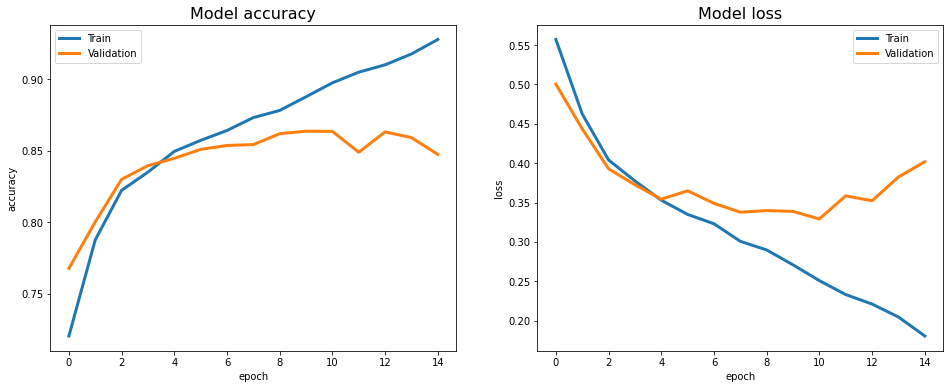

In [ ]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

# summarize history for accuracy
axis1.plot(history.history['accuracy'] , label='Train', linewidth=3)
axis1.plot(history.history['val_accuracy'], label='Validation', linewidth=3)
axis1.set_title('Model accuracy', fontsize=16)
axis1.set_ylabel('accuracy')
axis1.set_xlabel('epoch')
axis1.legend(loc='upper left')

# summarize history for loss
axis2.plot(history.history['loss'], label='Train', linewidth=3)
axis2.plot(history.history['val_loss'], label='Validation', linewidth=3)
axis2.set_title('Model loss', fontsize=16)
axis2.set_ylabel('loss')
axis2.set_xlabel('epoch')
axis2.legend(loc='upper right')
plt.show()

In [ ]:
X_test_indices = tokenizer.texts_to_sequences(X_test)

X_test_indices = pad_sequences(X_test_indices, maxlen=maxLen, padding='post')

In [ ]:
model.evaluate(X_test_indices,Y_test)

313/313 [==============================] - 5s 15ms/step - loss: 0.3397 - accuracy: 0.8573


[0.3397085964679718, 0.8572999835014343]